# ERA5 preparation for bias correction

This notebook is for preparing hourly ERA5 data to be used for bias-correcting CMIP6 temperature and precipitation data. This will involve two things, done for both temperature (t2m) and precipitation (tp):
1. summarize daily variables
2. Re-grid to common CMIP6 grid

## Summarize to daily

We want to generate the following daily summary variables:
* t2mmin
* t2m
* t2mmax 
* tp

Hourly data is available on UAF infrastructure at http://era5data.gi.alaska.edu/. Copy it to a scratch directory.

Set up the env:

In [2]:
from pathlib import Path
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe

In [3]:
src_dir = Path("/center1/CMIP6/kmredilla/era5")
src_t2m_dir = src_dir.joinpath("t2m")
src_tp_dir = src_dir.joinpath("tp")

out_dir = Path("/center1/CMIP6/kmredilla/era5/daily/")
out_dir.mkdir(exist_ok=True)
# make another out_dir for regridded era5
out_regrid_dir = Path("/center1/CMIP6/kmredilla/era5/daily_regrid/")
out_regrid_dir.mkdir(exist_ok=True)

# dir for dask logs
log_dir = src_dir.joinpath("slurm_logs")
log_dir.mkdir(exist_ok=True)

# Temperature dirs
t2mmin_dir = out_dir.joinpath("t2mmin")
t2m_dir = out_dir.joinpath("t2m")
t2mmax_dir = out_dir.joinpath("t2mmax")
t2mmin_dir.mkdir(exist_ok=True)
t2m_dir.mkdir(exist_ok=True)
t2mmax_dir.mkdir(exist_ok=True)

# precip dirs
tp_dir = out_dir.joinpath("tp")
tp_dir.mkdir(exist_ok=True)

out_tmp_fn = "era5_daily_{var_id}_{year}.nc"
out_tmp_regrid_fn = "era5_daily_regrid_{var_id}_{year}.nc"

# not sure exactly what our historical period will be yet
start_year = 1981
end_year = 2022

Start a cluster and client, scale the cluster (scaling it actually starts the slurm job I believe):

In [4]:
cluster = SLURMCluster(
    cores=16,
    processes=2,
    memory="64GB",
    queue="t2small",
    walltime="06:00:00",
    log_directory=str(log_dir),
    account="cmip6",
    interface="ib0",
)

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.55.40.4:8787/status,
Dashboard: http://10.55.40.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.55.40.4:40975,Workers: 0
Dashboard: http://10.55.40.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
cluster.scale(1)

Iterate over years and process the temperature variables, writing outputs to a single file for each year.
We will do 1981 to 2014 for now (copying this [downscaling paper](https://www.nature.com/articles/s41597-023-02528-x)).

In [8]:
for year in range(start_year, end_year + 1):
    fps = list(src_t2m_dir.glob(f"*{year}*.nc"))
    ds = xr.open_mfdataset(fps)
    # subset to panarctic domain
    pa_ds = ds.sel(latitude=slice(90, 50))

    pa_ds.resample(time="1D").min().rename({"t2m": "t2mmin"}).to_netcdf(
        t2mmin_dir.joinpath(out_tmp_fn.format(var_id="t2mmin", year=year))
    )
    pa_ds.resample(time="1D").mean().to_netcdf(
        t2m_dir.joinpath(out_tmp_fn.format(var_id="t2m", year=year))
    )
    pa_ds.resample(time="1D").max().rename({"t2m": "t2mmax"}).to_netcdf(
        t2mmax_dir.joinpath(out_tmp_fn.format(var_id="t2mmax", year=year))
    )
    print(f"{year} done", end=",")

2015 done,2016 done,2017 done,2018 done,2019 done,2020 done,2021 done,2022 done,

Do the same for the precip variable:

In [8]:
for year in range(start_year, end_year + 1):
    fps = list(src_tp_dir.glob(f"*{year}*.nc"))
    ds = xr.open_mfdataset(fps)
    pa_ds = ds.sel(latitude=slice(90, 50))

    pa_ds.resample(time="1D").sum().to_netcdf(
        tp_dir.joinpath(out_tmp_fn.format(var_id="tp", year=year))
    )
    print(f"{year} done", end=",")

### Quick QC

Do some quick checks on this data.

Compare the min, mean, and max temp values for a given day:

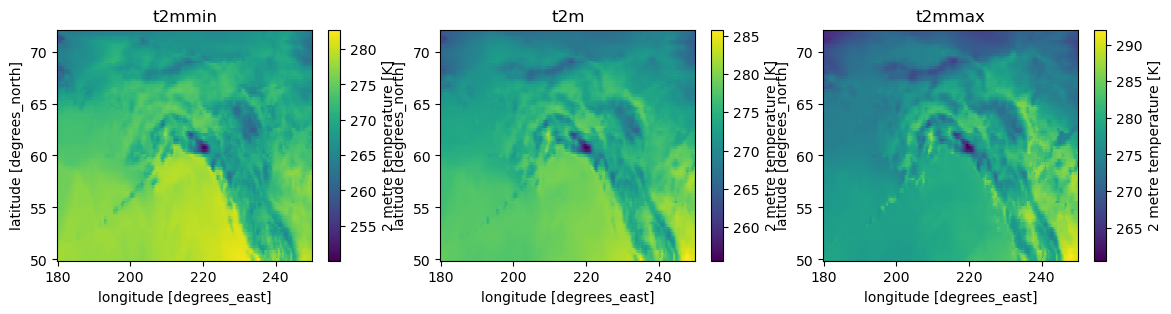

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

# choose a ranbdom day (it will be used below for regridding check as well)
iday = np.random.randint(0, 364)

year = "1981"
sel_di = dict(longitude=slice(180, 250), latitude=slice(72, 50))

for var_id, ax in zip(["t2mmin", "t2m", "t2mmax"], axes):
    with xr.open_dataset(
        out_dir.joinpath(var_id, out_tmp_fn.format(var_id=var_id, year=year))
    ) as ds:
        ds[var_id].isel(time=iday).sel(sel_di).plot(ax=ax)
    ax.set_title(var_id)

The differences are subtle, but evident. 

Precip plot:

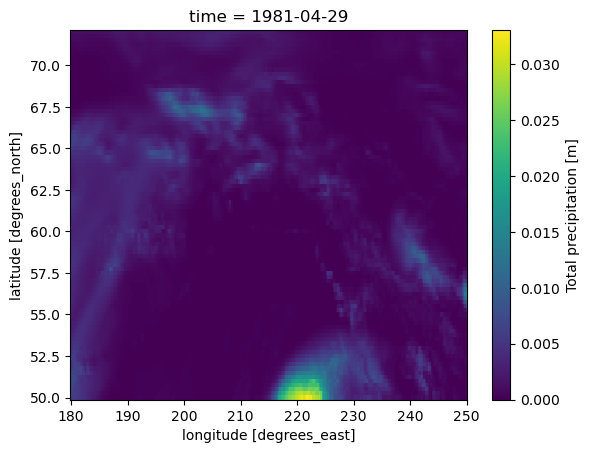

In [10]:
var_id = "tp"
with xr.open_dataset(
    out_dir.joinpath("tp", out_tmp_fn.format(var_id=var_id, year=year))
) as ds:
    ds[var_id].isel(time=iday).sel(sel_di).plot()

Sanity check some random pixels for expected values:

In [11]:
def test_resampling(var_id, year):
    """Test that the resampling done for a given variable is correct for a sample of pixels"""
    with xr.open_dataset(
        out_dir.joinpath(var_id, out_tmp_fn.format(var_id=var_id, year=year))
    ) as ds:
        ts = ds.time.isel(time=np.random.randint(364)).values

        if var_id == "tp":
            src_dir = src_tp_dir
            src_var_id = "tp"
        else:
            src_dir = src_t2m_dir
            src_var_id = "t2m"

        month = str(ds.sel(time=ts).time.dt.month.values).zfill(2)
        src_fp = list(src_dir.glob(f"*{year}_{month}*.nc"))[0]
        src_ds = xr.open_dataset(src_fp)
        # get date without time to select all hours in a given day
        date_str = np.expand_dims(ds.sel(time=ts).time.dt.date.data, axis=0)[
            0
        ].strftime("%Y-%m-%d")
        day_ds = src_ds.sel(time=date_str)
        if var_id == "t2mmin":
            src_aggr = day_ds.min(dim="time")
        elif var_id == "t2m":
            src_aggr = day_ds.mean(dim="time")
        elif var_id == "t2mmax":
            src_aggr = day_ds.max(dim="time")
        elif var_id == "tp":
            src_aggr = day_ds.sum(dim="time")

        # pick some random points and check
        n = 10
        tmp = ds[var_id].sel(time=ts)
        test_lats = np.random.choice(tmp.latitude.values, n)
        test_lons = np.random.choice(tmp.longitude.values, n)
        tests = [
            tmp.sel(latitude=lt, longitude=ln).values
            == src_aggr[src_var_id].sel(latitude=lt, longitude=ln)
            for lt, ln in zip(test_lats, test_lons)
        ]
        assert all(tests)

Test a random assortment of years and the summary variables through iteration. No output indicates indicates a passing test. 

In [12]:
for i in range(100):
    var_id = np.random.choice(["t2mmin", "t2m", "t2mmax", "tp"])
    year = np.random.randint(start_year, end_year)
    test_resampling(var_id, year)

## Re-grid ERA5 to CMIP6 common grid

I'm not sure if this is required or not, but after some exploration, it seems to make sense purely from an efficieny standpoint. I was getting some memory allocation errors during attempts to bias-adjust CMIP6 data. They could potentially be averted with dask, but we don't really need to use ERA5 at it's native resolution, since the goal is not downscaling CMIP6 data to ERA5 but rather keeping it on the common grid. The CMIP6 data is ~5% the size of ERA5 data (323MB for a single year of ERA5 data vs 18MB for a single year of CMIP6 data).

So, we will re-grid the ERA5 data to the CMIP6 common grid, and make some other adjustments to finish prepping it for bias-adjustment.

In [8]:
src_fp = out_dir.joinpath("t2m", "era5_daily_t2m_1981.nc")
src_ds = xr.open_dataset(src_fp)

# sample cmip6 target grid
# cmip6_fp = "/beegfs/CMIP6/arctic-cmip6/regrid/GFDL-ESM4/historical/day/tasmin/tasmin_day_GFDL-ESM4_historical_regrid_19810101-19811231.nc"
cmip6_fp = "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/ssp245/Amon/tas/tas_Amon_GFDL-ESM4_ssp245_regrid_201601-201612.nc"
cmip6_ds = xr.open_dataset(cmip6_fp)

Initialize regridder:

In [9]:
regridder = xe.Regridder(src_ds, cmip6_ds, "bilinear", unmapped_to_nan=True)

Iterate over years and variables, convert, write:

In [33]:
for year in range(start_year, end_year + 1):
    for var_id in ["t2m", "t2mmin", "t2mmax", "tp"]:
        tmp_fp = out_dir.joinpath(var_id, f"era5_daily_{var_id}_{year}.nc")
        tmp_ds = xr.open_dataset(tmp_fp)
        regrid_task = regridder(tmp_ds, keep_attrs=True)
        regrid_ds = regrid_task.compute()
        assert var_id in regrid_ds.data_vars

        out_fp = out_regrid_dir.joinpath(
            var_id, out_tmp_regrid_fn.format(var_id=var_id, year=year)
        )
        out_fp.parent.mkdir(exist_ok=True)
        regrid_ds.to_netcdf(out_fp)

    print(f"{year} done", end=", ")

1981 done, 1982 done, 1983 done, 1984 done, 1985 done, 1986 done, 1987 done, 1988 done, 1989 done, 1990 done, 1991 done, 1992 done, 1993 done, 1994 done, 1995 done, 1996 done, 1997 done, 1998 done, 1999 done, 2000 done, 2001 done, 2002 done, 2003 done, 2004 done, 2005 done, 2006 done, 2007 done, 2008 done, 2009 done, 2010 done, 2011 done, 2012 done, 2013 done, 2014 done, 2015 done, 2016 done, 2017 done, 2018 done, 2019 done, 2020 done, 2021 done, 

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


2022 done, 

Again, have a look at some of the files:

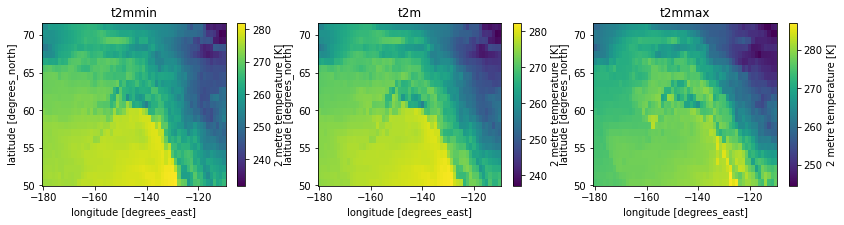

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

year = "1981"
# subsetting to Alaska
sel_di = dict(lon=slice(-180, -110), lat=slice(50, 72))

for var_id, ax in zip(["t2mmin", "t2m", "t2mmax"], axes):
    with xr.open_dataset(
        out_regrid_dir.joinpath(
            var_id, out_tmp_regrid_fn.format(var_id=var_id, year=year)
        )
    ) as ds:
        # using same day value as above
        ds[var_id].isel(time=iday).sel(sel_di).plot(ax=ax)
    ax.set_title(var_id)

## Create a DTR variable

Create a daily temperature range variable for adjusting the CMIP6 DTR:

In [42]:
dtr_dir = out_regrid_dir.joinpath("dtr")
dtr_dir.mkdir(exist_ok=True)


for t2mmax_fp in sorted(out_regrid_dir.glob("t2mmax/*.nc")):
    t2mmax_ds = xr.open_dataset(t2mmax_fp)
    year = int(t2mmax_ds.time.dt.year.isel(time=0).values)
    t2mmin_fp = out_regrid_dir.joinpath(
        "t2mmin", out_tmp_regrid_fn.format(var_id="t2mmin", year=year)
    )
    t2mmin_ds = xr.open_dataset(t2mmin_fp)
    dtr = t2mmax_ds["t2mmax"] - t2mmin_ds["t2mmin"]

    units = t2mmax_ds["t2mmax"].attrs["units"]
    assert units == t2mmin_ds["t2mmin"].attrs["units"]

    dtr.name = "dtr"
    dtr.attrs = {
        "long_name": "Daily temperature range",
        "units": units,
    }
    # replace any negative values (tasmax - tasmin < 0) with 0.0000999
    # using this number instead of zero gives us a way of estimating what spots were tweaked
    # include the isnull() check so we don't replace nan's
    assert dtr.min() >= 0

    dtr_ds = dtr.to_dataset()[["time", "lat", "lon", "dtr"]]
    dtr_ds.attrs = {k: v for k, v in t2mmax_ds.attrs.items() & t2mmin_ds.attrs.items()}

    out_dtr_fp = out_regrid_dir.joinpath(
        "dtr", out_tmp_regrid_fn.format(var_id="dtr", year=year)
    )
    dtr_ds.to_netcdf(out_dtr_fp)
    print(f"{year} done", end=", ")

1981 done, 1982 done, 1983 done, 1984 done, 1985 done, 1986 done, 1987 done, 1988 done, 1989 done, 1990 done, 1991 done, 1992 done, 1993 done, 1994 done, 1995 done, 1996 done, 1997 done, 1998 done, 1999 done, 2000 done, 2001 done, 2002 done, 2003 done, 2004 done, 2005 done, 2006 done, 2007 done, 2008 done, 2009 done, 2010 done, 2011 done, 2012 done, 2013 done, 2014 done, 2015 done, 2016 done, 2017 done, 2018 done, 2019 done, 2020 done, 2021 done, 2022 done, 

Move these data to a common location:

```
rsync -av /center1/CMIP6/kmredilla/era5/daily_regrid /beegfs/CMIP6/arctic-cmip6/era5
```